## 代码实现


上面我们已经了解了对极约束的基本概念和数学推导，以及如何通过对极约束计算基础矩阵和进行三角测量。接下来这一节我们将动手学如何基于两张给定的不同视角图像计算它们之间的基础矩阵并进行三角测量。

In [1]:
# 首先clone对应仓库
!git clone https://github.com/boyu-ai/Hands-on-CV.git

Cloning into 'Hands-on-CV'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 9 (delta 1), reused 5 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (9/9), done.
Resolving deltas: 100% (1/1), done.


In [2]:
import os, cv2, random
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

class FeatureExtractor:
    """
    构建类用于提取SIFT特征。
    """
    def __init__(self, image):
        """
        初始化FeatureExtractor类。
        
        参数:
        - image: (np.ndarray): RGB 形式的图像。
        """
        self.image = image
        # 将图像转换为灰度图
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        self.keypoints = None
        self.descriptors = None

    def extract_features(self):
        """
        使用OpenCV的内置函数提取图像中的SIFT特征。
        
        返回:
        - keys: (list): 特征点列表。
        - descriptors: (np.ndarray): 描述子。
        """
        sift = cv2.SIFT_create()
        keys, descriptors = sift.detectAndCompute(self.gray, None)

        # 如果特征点数量小于20个，返回None
        if len(keys) <= 20:
            return None, None
        else:
            self.keypoints = keys
            self.descriptors = descriptors
            return keys, descriptors

def vis_imgs(imgs):
    """
    可视化多张图像。

    参数:
    - imgs: 要可视化的图像列表。
    """
    # 计算图像数量
    num_imgs = len(imgs)
    # 创建画布
    fig = plt.figure(figsize=(10, 10))
    # 遍历每一张图像
    for i in range(num_imgs):
        # 添加子图
        ax = fig.add_subplot(1, num_imgs, i + 1)
        # 显示图像
        ax.imshow(imgs[i])
        # 关闭坐标轴
        ax.axis('off')
    # 显示画布
    plt.show()

为了方便，这里直接提供了照相机的内参（来自照相机本身的数据），当然也可以用在第 16 章中教过的标定获得的内参数据。

In [3]:
def load_instrinsic(path):
    """
    从文件中直接读取内参。
    """
    return np.loadtxt(path).astype(np.float32)

def construct_img_info(img_root):
    """
    从图像中获取特征信息。
    """
    imgs = []
    feats = []
    K = []
    for _, name in enumerate(os.listdir(img_root)):
        if '.jpg' in name or '.JPG' or '.png' in name:
            # 读取图像
            path = os.path.join(img_root, name)
            img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
            imgs.append(img)

            # 提取特征
            feature_ext = FeatureExtractor(img)
            kpt, des = feature_ext.extract_features()

            # 读取内参
            K = load_instrinsic(os.path.join(
                os.path.dirname(img_root), 'K.txt'))
            feats.append({'kpt': kpt, 'des': des})
    return imgs, feats, K

接下来我们计算两张图像间的对应关系，查询并匹配两者之间的特征。

In [4]:
def get_matches(des_query, des_train):
    """
    匹配相关图像特征。

    参数:
    - des_query: (np.ndarray): 查询描述子。
    - des_train: (np.ndarray): 训练描述子。

    返回:
    - goods: (list): 匹配结果。
    """
    # 创建匹配器
    bf = cv2.BFMatcher(cv2.NORM_L2)
    # 获取匹配结果
    matches = bf.knnMatch(des_query, des_train, k=2)
    # 创建goods列表用于存储有用的匹配结果
    goods = []
    # 遍历所有匹配结果
    for m, m_ in matches:
        # 设置阈值为0.65，保留更多的特征
        if m.distance < 0.65 * m_.distance:
            goods.append(m)
    return goods

def get_match_point(p, p_, matches):
    """
    寻找匹配的关键点。

    参数:
    - p: (list[cv2.KeyPoint]): 查询关键点。
    - p_: (list[cv2.KeyPoint]): 训练关键点。
    - matches: (list[cv2.DMatch]): 匹配信息。

    返回:
    - points_query: (np.ndarray): 查询关键点。
    - points_train: (np.ndarray): 训练关键点。
    """
    # 从查询关键点中找到匹配的关键点
    points_query = np.asarray([p[m.queryIdx].pt for m in matches])
    # 从训练关键点中找到匹配的关键点
    points_train = np.asarray([p_[m.trainIdx].pt for m in matches])
    # 返回匹配的查询和训练关键点
    return points_query, points_train

def homoco_pts_2_euco_pts(pts):
    """
    齐次坐标转化为欧几里得坐标。
    """
    if len(pts.shape) == 1:
        pts = pts.reshape(1, -1)
    res = pts / pts[:, -1, None]
    return res[:, :-1].squeeze()

def euco_pts_2_homoco_pts(pts):
    """
    欧几里得坐标转化为齐次坐标。
    """
    if len(pts.shape) == 1:
        pts = pts.reshape(1, -1)
    one = np.ones(pts.shape[0])
    res = np.c_[pts, one]
    return res.squeeze()

def normalize(pts, T=None):
    """
    对点集进行归一化。
    """
    # 如果T参数为空
    if T is None:
        # 求点集的平均值
        u = np.mean(pts, 0)
        # 求点集中每个点与原点之间的距离之和
        d = np.sum(np.sqrt(np.sum(np.power(pts, 2), 1)))
        # 计算归一化矩阵
        T = np.array([
            [np.sqrt(2) / d, 0, -(np.sqrt(2) / d * u[0])],
            [0, np.sqrt(2) / d, -(np.sqrt(2) / d * u[1])],
            [0, 0, 1]
        ])
    # 将点集进行归一化
    return homoco_pts_2_euco_pts(np.matmul(T, 
                euco_pts_2_homoco_pts(pts).T).T), T

到这里我们就已经得到了两张图之间的对应像素关系，接下来使用八点法计算基础矩阵。

In [5]:
def estimate_fundamental(pts1, pts2, num_sample=8):
    """
    计算基础矩阵。

    参数:
    - pts1: (np.ndarray)：匹配特征所得到的训练点集。
    - pts2: (np.ndarray)：匹配特征所得到的查询点集。

    返回:
    - f: (np.ndarray): 基础矩阵。
    """
    n = pts1.shape[0]
    pts_index = range(n)
    sample_index = random.sample(pts_index, num_sample)
    p1 = pts1[sample_index, :]
    p2 = pts2[sample_index, :]
    n = len(sample_index)
    # 归一化点集坐标
    p1_norm, T1 = normalize(p1, None)
    p2_norm, T2 = normalize(p2, None)
    w = np.zeros((n, 9))
    # 构建A矩阵
    for i in range(n):
        w[i, 0] = p1_norm[i, 0] * p2_norm[i, 0]
        w[i, 1] = p1_norm[i, 1] * p2_norm[i, 0]
        w[i, 2] = p2_norm[i, 0]
        w[i, 3] = p1_norm[i, 0] * p2_norm[i, 1]
        w[i, 4] = p1_norm[i, 1] * p2_norm[i, 1]
        w[i, 5] = p2_norm[i, 1]
        w[i, 6] = p1_norm[i, 0]
        w[i, 7] = p1_norm[i, 1]
        w[i, 8] = 1
    # svd分解
    U, sigma, VT = np.linalg.svd(w)
    f = VT[-1, :].reshape(3, 3)
    U, sigma, VT = np.linalg.svd(f)
    sigma[2] = 0
    f = U.dot(np.diag(sigma)).dot(VT)
    # 逆归一化
    f = T2.T.dot(f).dot(T1)

    ### 随机计算的F矩阵误差较大，使用OpenCV中的函数(RANSAC)计算F矩阵
    pts1 = pts1.astype(np.float32)
    pts2 = pts2.astype(np.float32)
    f, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

    return f

def convert_F_to_E(F_single, K):
    """
    根据F矩阵计算E矩阵。
    """
    inverse_K = np.linalg.inv(K)
    E_single = inverse_K.T.dot(F_single).dot(inverse_K)
    return E_single

def get_Rt_from_E(E_single,K,pts1,pts2):
    """
    根据E矩阵计算Rt，使用OpenCV的函数recoverPose。
    """
    # OpenCV的recoverPose函数已经自动去除了不合理的3个解
    _, R, t, _ = cv2.recoverPose(E_single, pts1, pts2, K) 
    return R, t

def build_F_E_matrix(feats, K):
    """
    计算基础矩阵F，本质矩阵E，从E中分离出Rt并返回。
    """
    pair = dict()
    match = dict()
    Rts = dict()

    for i in range(len(feats)):
        for j in range(i + 1, len(feats)):
            matches = get_matches(
                feats[i]['des'], feats[j]['des'])
            pts1, pts2 = get_match_point(
                feats[i]['kpt'], feats[j]['kpt'], matches)
            assert pts1.shape == pts2.shape
            
            # 至少需要8个点来计算F矩阵
            if pts1.shape[0] < 8:
                continue
            # 计算F矩阵
            F_single = estimate_fundamental(pts1, pts2)
            # 根据F矩阵计算E矩阵
            E_single = convert_F_to_E(F_single, K)
            # 从E矩阵中得到相对位姿
            R, t = get_Rt_from_E(E_single, K, pts1, pts2)

            if pts1.shape[0] < 8:
                continue

            pair.update({(i, j): {'pts1': pts1, 'pts2': pts2}})
            match.update({(i, j): {'match': matches}})
            Rts.update({(i, j): {'R': R, 't': t}})

    return F_single, E_single, pair, match, Rts

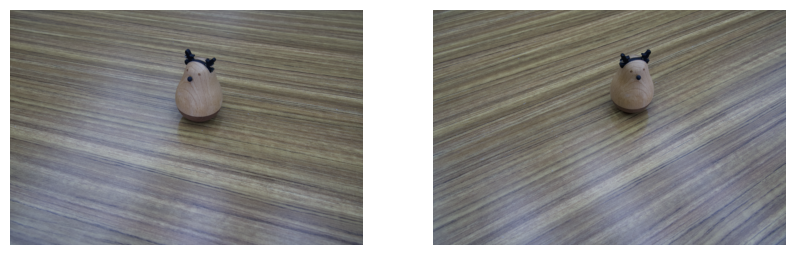

基础矩阵为:
 [[ 5.17116489e-06 -9.35405231e-06 -1.13783351e-03]
 [ 5.94850943e-06  1.16772622e-05 -5.72937517e-03]
 [-2.94980264e-03  3.55455633e-03  1.00000000e+00]]
本质矩阵为:
 [[ 1.80790150e-11 -3.27683889e-11 -2.12631708e-06]
 [ 2.08383558e-11  4.09888034e-11 -1.07495911e-05]
 [-5.52573986e-06  6.66134548e-06  1.00331656e+00]]
第一副图像对应的矩阵为:
 [[534.81896973   0.         320.           0.        ]
 [  0.         533.75       213.           0.        ]
 [  0.           0.           1.           0.        ]]
第二幅图像对应的矩阵为:
 [[ 6.02699217e+02 -1.32348682e+02 -8.75717417e+01  5.27600711e+02]
 [ 1.51538241e+02 -1.73321278e+02  5.26549104e+02  8.74049809e+01]
 [ 3.23134701e-01 -9.46352981e-01  1.82851868e-05  3.84515925e-06]]


In [6]:
img_root = 'Hands-on-CV/第19章 三维重建/images'
imgs, feats, K = construct_img_info(img_root)
# 可视化图像
vis_imgs(imgs)

F, E, pair, match, Rts = build_F_E_matrix(feats, K)
print("基础矩阵为:\n", F)
print("本质矩阵为:\n", E)

# 不妨假定第一张图为世界坐标系
R_t_0 = np.array([[1,0,0,0], [0,1,0,0], [0,0,1,0]])
R_t_1 = np.empty((3,4))
R_t_1[:,:3] = Rts[(0,1)]['R']
R_t_1[:,3] = Rts[(0,1)]['t'].reshape(3)
P_0 = K.dot(R_t_0)
P_1 = K.dot(R_t_1)
print("第一副图像对应的矩阵为:\n", P_0)
print("第二幅图像对应的矩阵为:\n", P_1)

在得到了基础矩阵之后，我们就可以通过三角测量计算出三维空间点的坐标。

In [7]:
def filter_matches_by_epipolar(pts1, pts2, F, threshold=3.0):
    """
    使用对极约束过滤匹配点
    
    参数:
    - pts1, pts2: 匹配点对。
    - F: 基础矩阵。
    - threshold: 对极误差阈值。
        
    返回:
    - pts1_filtered, pts2_filtered: 过滤后的匹配点。
    """
    pts1_reshaped = pts1.T.reshape(-1,1,2)
    pts2_reshaped = pts2.T.reshape(-1,1,2)
    
    # 计算两幅图像的极线
    lines1 = cv2.computeCorrespondEpilines(pts2_reshaped, 2, F)
    lines2 = cv2.computeCorrespondEpilines(pts1_reshaped, 1, F)
    
    dist1 = np.abs(np.sum(lines1.reshape(-1,3) * 
                 np.hstack((pts1.T, np.ones((pts1.shape[1],1)))), axis=1))
    dist2 = np.abs(np.sum(lines2.reshape(-1,3) * 
                 np.hstack((pts2.T, np.ones((pts2.shape[1],1)))), axis=1))
    
    mask = (dist1 < threshold) & (dist2 < threshold)
    return pts1[:,mask], pts2[:,mask]

pts1 = np.transpose(pair[(0,1)]['pts1'])
pts2 = np.transpose(pair[(0,1)]['pts2'])
# 过滤匹配点
pts1_filtered, pts2_filtered = filter_matches_by_epipolar(pts1, pts2, F)
print("过滤前的匹配点数量为: ", pts1.shape[1])
print("过滤后的匹配点数量为: ", pts1_filtered.shape[1])

# 三角测量获得空间点坐标
points_3d = cv2.triangulatePoints(P_0, P_1, pts1_filtered, pts2_filtered)
# 齐次坐标的最后一行为1，需要除以最后一行
points_3d /= points_3d[3]
points_3d = points_3d[:3, :].T
print("得到的三维点为:\n", points_3d)

# 计算有效点占像素比例
print("检测到的点占图像像素的比例为: {:02f}%".format(
    points_3d.shape[0]/len(imgs[0][...,0].flatten())*100))

过滤前的匹配点数量为:  16
过滤后的匹配点数量为:  13
得到的三维点为:
 [[-0.60458395 -0.01198244  0.0969504 ]
 [-0.58099777 -0.21461379  0.05341815]
 [-0.47523613 -0.39286399 -0.15945556]
 [-0.56740703 -0.24286074 -0.00477856]
 [-0.49754951 -0.36653935 -0.14429421]
 [-0.47079379 -0.40467599 -0.19146369]
 [-0.55889738 -0.26988774 -0.09548055]
 [-0.60761656 -0.14041958 -0.12032324]
 [-0.56458993 -0.29775277 -0.2171921 ]
 [-0.6082215  -0.14859759 -0.13404173]
 [-0.43299244 -0.4819224  -0.33418579]
 [-0.5657818  -0.3328847  -0.29034157]
 [-0.5657818  -0.3328847  -0.29034157]]
检测到的点占图像像素的比例为: 0.004757%


可以发现，存在部分匹配点不严格遵循对极约束。接下来我们可视化极线和匹配点。

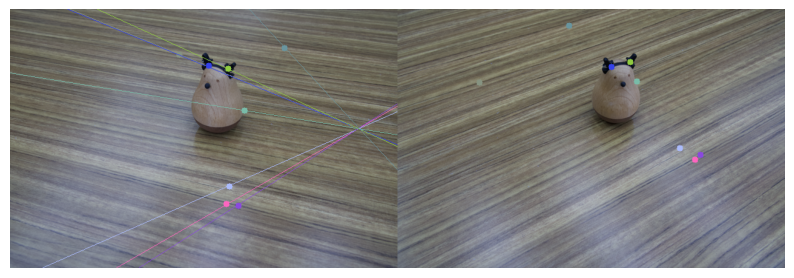

In [8]:
def draw_epipolar_lines(pts1, pts2, img1, img2, F):
    """
    绘制极线。

    参数:
    - pts1: (np.ndarray): 第一幅图像中的匹配点。
    - pts2: (np.ndarray): 第二幅图像中的匹配点。
    - img1: (np.ndarray): 第一幅图像。
    - img2: (np.ndarray): 第二幅图像。
    - F: (np.ndarray): 基础矩阵。
    """
    # 将点坐标转为整数
    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)

    # 选取前8个点进行可视化
    idx = np.arange(8)
    pts1 = pts1[idx]
    pts2 = pts2[idx]

    # 计算对应的极线
    lines1 = cv2.computeCorrespondEpilines(
                        pts2.reshape(-1,1,2), 2, F)
    lines1 = lines1.reshape(-1,3)

    # 绘制极线
    imgl, imgr = drawlines(img1, img2, lines1, pts1, pts2)

    # 将两幅图拼接在一起
    vis = np.concatenate((imgl, imgr), axis=1)

    # 展示图像
    plt.figure(figsize=(10, 10))
    plt.imshow(vis)
    plt.axis('off')
    plt.show()

def drawlines(img1, img2, lines, pts1, pts2):
    """
    绘制极线。

    参数:
    - img1: (np.ndarray): 左图。
    - img2: (np.ndarray): 右图。
    - lines: (np.ndarray): 极线。
    - pts1: (np.ndarray): 左图对应的匹配点。
    - pts2: (np.ndarray): 右图对应的匹配点。
    """
    # 获取图像尺寸
    r, c, _ = img1.shape

    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(50, 255, 3).tolist())
        # 计算直线上的两个点
        x0, y0 = map(int, [0, -r[2]/r[1]]) 
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        # 在img1中绘制直线
        img1 = cv2.line(img1,  (x0, y0),  (x1, y1),  color, 1) 
        # 在img1中绘制对应的特征点
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1) 
        # 在img2中绘制对应的特征点
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1) 
    return img1, img2

# 在原图上可视化特征点对应的极线
draw_epipolar_lines(pts1_filtered.T, pts2_filtered.T, 
                    imgs[0], imgs[1], F)